<a href="https://colab.research.google.com/github/davidogm/DataScience/blob/main/ITBD/notebooks/Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color="red">Reference Document</font>


- <a href="https://github.com/dask/dask-tutorial">dask-tutorial</a>
- <a href="https://www.manning.com/books/data-science-with-python-and-dask">Data Science with Python and Dask</a>
- <a href="https://www.manifold.ai/dask-and-machine-learning-preprocessing-tutorial">Dask and Machine Learning: Preprocessing Tutorial</a>
- <a href="https://carpentries-incubator.github.io/lesson-parallel-python/aio/index.html">Parallel Programming in Python</a>
- <a href="https://www.youtube.com/watch?v=uGy5gT2vLdI&feature=youtu.be"> Working with the Python DASK library (video)</a>
- <a href="https://www.youtube.com/watch?v=t_GRK4L-bnw&feature=youtu.be">Who uses Dask (video)</a>

![fig_dask](https://miro.medium.com/max/1000/1*D6mSsdWECFLn6wJne4VTjg.png)



## Dask Array

Pequeña introducción a DASK, básica, rápida y con ejemplos



# **Dask Dataframes**

Dask is a flexible parallel computing library for analytic computing written in Python. Dask is similar to Spark, by lazily constructing directed acyclic graph (DAG) of tasks and splitting large datasets into small portions called partitions.

See the below image from Dask's web page for illustration.

Una de las imágenes representativas de DASK, en comparación a Spark y al procesamieno en paralelo.


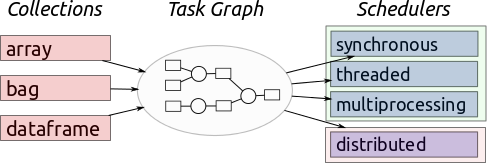

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [71]:
import dask
import dask.array as da
import dask.dataframe as dd

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Otra de las imágenes características de DASK, con las divisiones de arrays:

Las matrices Dask coordinan muchas matrices Numpy, organizadas en trozos (chunks) dentro de una cuadrícula.

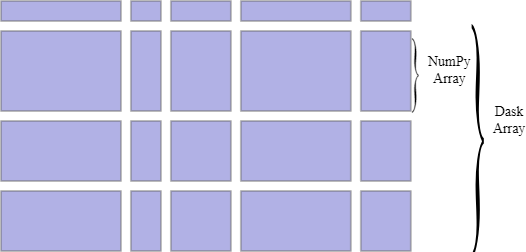

In [9]:
# arrays de dimensiones que le indicamos, en este caso 25 números partidos en 5 chunks
x = da.arange(25, chunks=5)
x

dask.array<arange, shape=(25,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

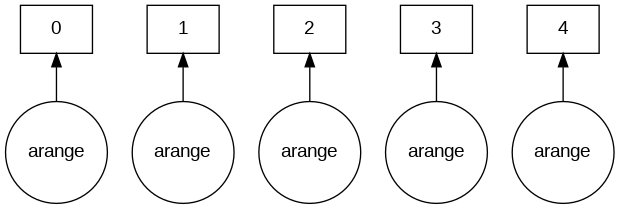

In [10]:
x.visualize()

In [12]:
y = x ** 2
y

dask.array<pow, shape=(25,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

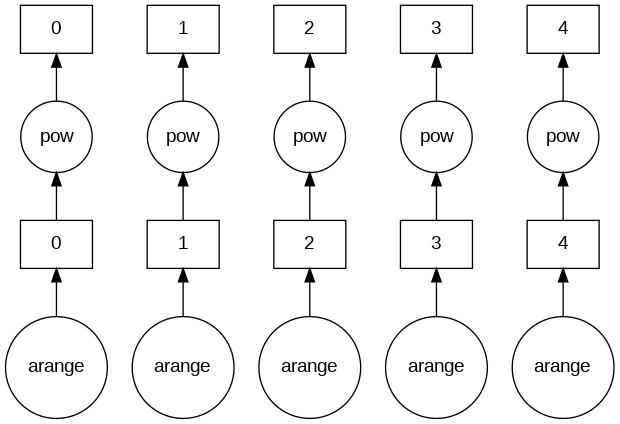

In [13]:
# hay 5 branches (hilos de ejecución) en paralelo
y.visualize()

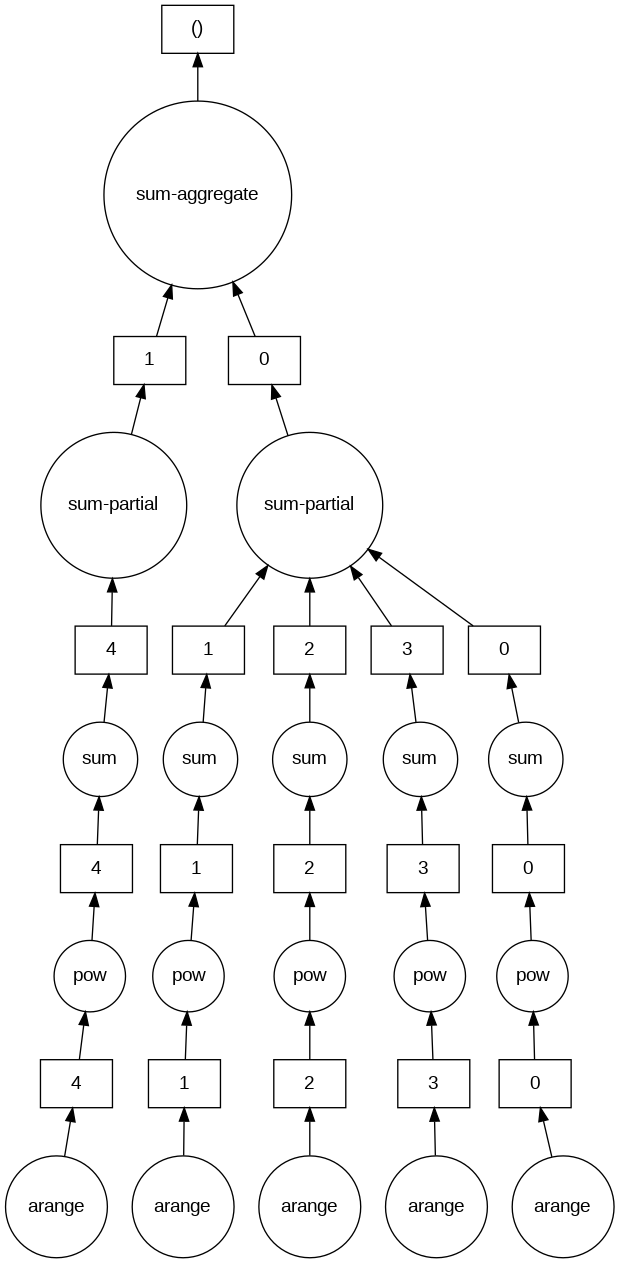

In [14]:
y.sum().visualize()

In [ ]:
y.compute()

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

In [ ]:
y.compute(scheduler='processes')  # esto se puede cambiar según los procesadores o como queramos hacer los hilos de ejecución, probar

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

In [ ]:
x.compute()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

Calculemos los tiempos normales y con dask

In [4]:
import time

def increment(x):
    time.sleep(1.0)
    return x + 1

def double(x):
    time.sleep(1.0)
    return 2 * x

def add(x, y):
    time.sleep(1.0)
    return x + y

In [5]:
%%time

x = increment(1)
y = increment(2)
z = add(x, y)

CPU times: user 18.1 ms, sys: 2.49 ms, total: 20.6 ms
Wall time: 3 s


- We use the `dask.delayed` decorator to parallelize the functions `increment` and `add`.
- By decorating the functions, we record what we want to compute as tasks into graphs that will be run later on parallel hardware.



Lo vemos con un ejemplo y lo que hacemos es tener 3 funciones diferentes que son xd, yd y zd que se pueden ejecutar de forma paralela y poner delayed para cada una de ellas

In [16]:
import dask

xd = dask.delayed(increment)(1)
yd = dask.delayed(increment)(2)
zd = dask.delayed(add)(xd, yd)
zd

Delayed('add-ec8f63ca-db4d-4851-92d1-05cf09f810bb')

- When we call the delayed version by passing the arguments, exactly as before, but the original function isn't actually called yet.
- A delayed object is made, which keeps track of the function to call and the arguments to pass to it.
- We use the `visualize` method (relies on the `graphviz` package) that provide a visual representation of the operations being performed.

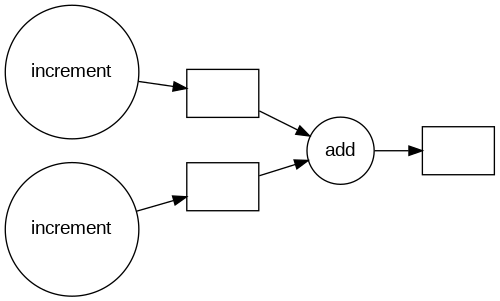

In [17]:
zd.visualize(rankdir='LR')

- Note that we have not physically calculated **total** yet.
- We need to apply the `compute` method to get the answer.
- <font color="red">It is only here that the data are loaded into memory for calculations</font>.
- The calculations are done through using a local thread pool.

In [18]:
%%time
dask.compute(zd)

CPU times: user 414 ms, sys: 49.1 ms, total: 463 ms
Wall time: 2.74 s


(5,)

**Using `delayed` in Loops**

`delayed` permite ejecutar funciones de forma paralela y poner delayed para cada una de ellas


Empezamos con el código secuencial con dos bucles for::

In [19]:
%%time

n = 10
data = [i+1 for i in range(n)]

out = list()
for x in data:
    y = increment(x)
    z = double(y)
    out.append(z)

total = 0
for z in out:
    total = add(total, z)

total

CPU times: user 130 ms, sys: 18.9 ms, total: 149 ms
Wall time: 30 s


130

tarda bastante... lógico cuando hablamos de bucles

Es el ejemplo claro que como podemos paralelizarlo utilizando el `delayed`:

reduciendo mucho su tiempo de ejecución




In [23]:
%%time

n = 10
data = [i+1 for i in range(n)]

out = list()
for x in data:
    y = dask.delayed(increment)(x)
    z = dask.delayed(double)(y)
    out.append(z)

totald = 0
for z in out:
    totald = dask.delayed(add)(totald, z)

totald.compute()



CPU times: user 86.7 ms, sys: 9.38 ms, total: 96.1 ms
Wall time: 16 s


130

We can also get the visual representation through a task graph.

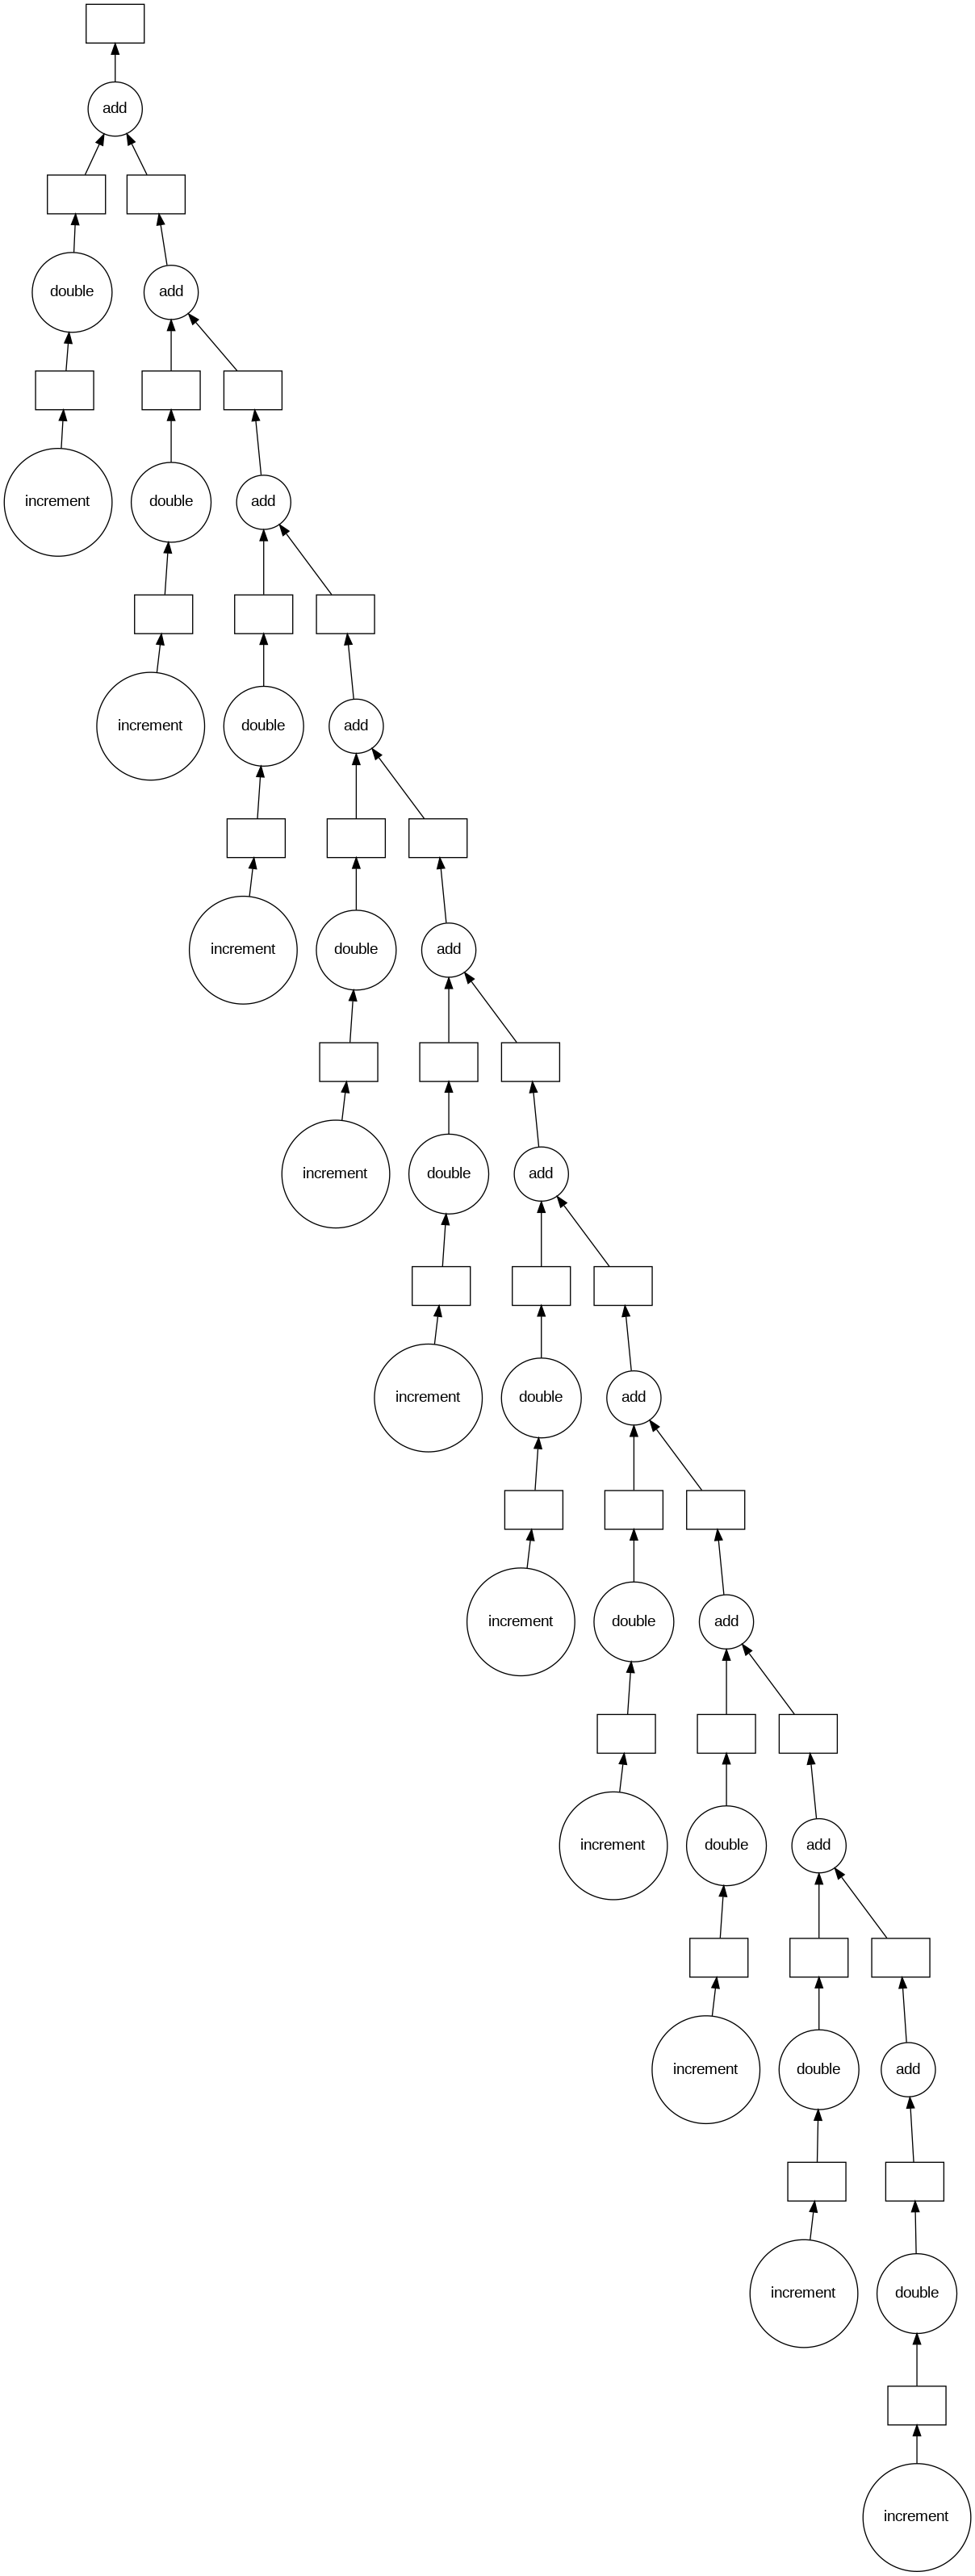

In [24]:
totald.visualize()

In [25]:
# por si queremos volver a calcular el tiempo inverido
%%time
dask.compute(totald)

CPU times: user 82.8 ms, sys: 9.09 ms, total: 91.9 ms
Wall time: 16 s


(130,)

### Ejemplo 1

Utilice `delayed` para paralelizar el código siguiente:

In [27]:
def is_odd(x):
    return x%2

In [28]:
%%time

n = 10
data = [i+1 for i in range(n)]

results = list()

for x in data:
    if is_odd(x):
        y = double(x)
    else:
        y = increment(x)
    results.append(y)

total = sum(results)
print(total)

85
CPU times: user 40.7 ms, sys: 11 ms, total: 51.7 ms
Wall time: 10 s


La solución es similar al primer ejemplo, en donde se puede separar por funciones y cada una de ellas tener el `delayed`

Tiempo reducido a la mitad y a medida que vayamos usando más `delayed` la reducción va siendo mayor

In [29]:
%%time

n = 10
data = [i+1 for i in range(n)]

results = list()

for x in data:
    if is_odd(x):
        y = dask.delayed(double)(x)
    else:
        y = dask.delayed(increment)(x)
    results.append(y)

total = dask.delayed(sum)(results)
total.compute()

CPU times: user 31.4 ms, sys: 3.35 ms, total: 34.7 ms
Wall time: 5.01 s


85

### Example: Palindromic Words

- A palindromic word is a word which characters read the same backward as forward.
- Some examples of palindromes are `redivider`, `deified`, `civic`, `radar`, `level`, `rotor`, `kayak`, `reviver`, `racecar`, `madam`, and `refer`.

We want to find the number of palindromes from a list of words.

Lo dejamos en inglés porque así están ls palabras

In [30]:
def is_palindrome(s):
    return s.upper() == s.upper()[::-1]

In [32]:
list_words = [
    'complete', 'abstraction', 'from', 'compass', 'sights', 'sounds',
    'Human', 'shapes', 'interferences', 'troubles', 'joys', 'were',
    'they', 'were', 'there', "man", 'seemed', 'shaded', 'hemisphere',
    'globe', 'sentient', 'being', 'save', 'himself', "rather",
    "Abba", "Aibohphobia", "Bib", "Bob", "Civic", "Deified",
    "Detartrated", "Dewed", "Eve", "Hannah", "Kayak", "Level",
    "Madam", "Malayalam", "Minim", "Mom", "Murdrum", "Noon", "Nun",
    "Otto", "Peep", "Pop", "Racecar", "Radar", "Redder", "Refer",
    "Repaper", "Rotator", "Rotavator", "Rotor", "Sagas",
    "Sis", "Solo", "Stats", "Tattarrattat", "Tenet",
    'redivider', 'deified', 'civic', 'radar', 'level',
    'Being', 'not', 'without', 'frequent', 'consciousness',
    'that', 'there', 'was', 'some', 'charm', 'this', 'life', 'stood',
    'still', 'after', 'looking', 'sky', 'useful', 'instrument',
    'regarded', 'appreciative', 'spirit', 'work', 'art',
    'superlatively', 'beautiful', 'moment', 'seemed',
    'impressed', 'with', 'speaking', 'loneliness', 'scene',
    "brother", "system", "SISteR", "TEXT", "paREnts", "python",
    "Numpy", "Dask", "PanDaS"
]

len(list_words)

108

**Using Regular Python**

In [39]:
%%time
palindromes_py = [is_palindrome(s) for s in list_words]
total_py = sum(palindromes_py)
total_py

CPU times: user 123 µs, sys: 0 ns, total: 123 µs
Wall time: 127 µs


40

**Using Dask**

In [34]:
palindromes_da = [dask.delayed(is_palindrome)(s) for s in list_words]
total_da = dask.delayed(sum)(palindromes_da)

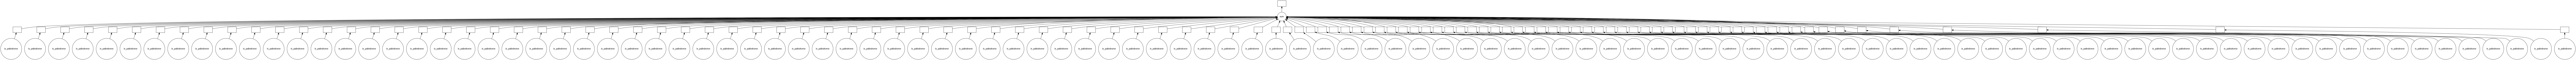

In [35]:
total_da.visualize()

In [38]:
%%time
result = total_da.compute()
result

CPU times: user 21.5 ms, sys: 753 µs, total: 22.3 ms
Wall time: 22 ms


40

**<font color="red">Importante </font>**

- `delayed` añade sobrecarga.
- Es bueno no utilizarlo cuando una tarea requiere poco tiempo.
- Dividir los cálculos en muchas partes. El paralelismo se consigue con muchas llamadas retardadas, no con una sola: Dask no mirará dentro de una función  `delayed` y paralelizará ese código internamente.

Use the **`compute()`** function if you want your result as a NumPy array.

In [43]:
mu[0].compute()

NameError: name 'mu' is not defined

In [ ]:
w = z.compute()
print(type(w), w.shape )

[########################################] | 100% Completed | 2.09 s
<class 'numpy.ndarray'> (20000,)


**Persit Data in Memory**

- If you have the available RAM for your dataset then you can persist data in memory.
- This allows future computations to be much faster.

In [44]:
%time y.sum().compute()

AttributeError: 'int' object has no attribute 'sum'

In [ ]:
y = y.persist()

[########################################] | 100% Completed | 6.56 s


In [ ]:
%time y[0, 0].compute()

[########################################] | 100% Completed | 104.06 ms
CPU times: user 12.4 ms, sys: 831 µs, total: 13.2 ms
Wall time: 112 ms


2.981269292999592

In [ ]:
%time y.sum().compute()

[########################################] | 100% Completed | 420.40 ms
CPU times: user 468 ms, sys: 55.1 ms, total: 523 ms
Wall time: 454 ms


999997842.5628786

**Numpy against Dask**

In [52]:
!pip install memory_profiler

In [54]:
from memory_profiler import memory_usage
import memory_profiler
%load_ext memory_profiler

In [45]:
def f_numpy():
    x = np.random.normal(10, 0.1, size=(20000, 20000))
    y = x.mean(axis=0)[::100]

`%%memit`

- Measures the memory use of a single statement.
- Provides the peak memory and incremental memory growth

In [55]:
%%memit
f_numpy()

peak memory: 3306.37 MiB, increment: 3052.33 MiB


In [56]:
%%time
f_numpy()

CPU times: user 13.7 s, sys: 662 ms, total: 14.3 s
Wall time: 14.4 s


Vemos en la comparativa como mejoramos el rendimieno de memoria, el de la CPU puede ser similar o mayor.

La explicación es que Dask termina más rápido, pero utiliza más tiempo total de CPU porque Dask es capaz de paralelizar de forma transparente el cálculo debido al tamaño de los trozos.

In [57]:
def f_dask():
    x = da.random.normal(10, 0.1, size=(20000, 20000),
                         chunks=(1000, 1000))
    y = x.mean(axis=0)[::100].compute()

In [58]:
%%memit
f_dask()

peak memory: 282.61 MiB, increment: 27.78 MiB


In [59]:
%%time
f_dask()

CPU times: user 20.2 s, sys: 51.4 ms, total: 20.2 s
Wall time: 12 s


y como podemos imaginar se puede reajustar el tamaño de los trozos(chunks) para mejorar el rendimiento:

In [61]:
def f_dask2():
    x = da.random.normal(10, 0.1, size=(20000, 20000),
                         chunks=(2000, 500))
    y = x.mean(axis=0)[::100].compute()

In [62]:
%%time
f_dask2()

CPU times: user 20.2 s, sys: 87.9 ms, total: 20.3 s
Wall time: 11.9 s


**Dask finished faster, but used more total CPU time because Dask was able to transparently parallelize the computation because of the chunk size.**


Consideraciones para tener en cuenta a la hora de explorar/investigar



**<font color="red">Things to Consider</font>**

- If your data fits in RAM and you are not performance bound, then using NumPy might be the right choice. Dask adds another layer of complexity which may get in the way.
- **If you are just looking for speedups rather than scalability then you may want to consider using Numba for manipulating Numpy arrays.**
- How to select the chunk size?
     - Too small: huge overheads.
     - Poorly aligned with data: inefficient reading.
     - Recommended to have a chuck size of at least 100 Mb.
     - Choose a chunk size that is large in order to reduce the number of chunks that Dask has to think about (which affects overhead) but also small enough so that many of them can fit in memory at once. Dask will often have as many chunks in memory as twice the number of active threads.
   

**Avoid Oversubscribing Threads**
     
- By default Dask will run as many concurrent tasks as you have logical cores.
- It assumes that each task will consume about one core.
- Many array-computing libraries (used in Dask) are themselves multi-threaded, which can cause contention and low performance.
- For better performance, we need to explicitly specify the use of one thread:

```bash
   export OMP_NUM_THREADS=1
   export MKL_NUM_THREADS=1
   export OPENBLAS_NUM_THREADS=1
```

## <font color="red">Memory Profiling</font>

- We use the `memory_profiler` package to track memory usage.
- It's written totally in python and monitors process which is running python code as well as line by line memory usage by code.
- We use the `memory_usage()` and pass the parameter `interval` for the frequency of measuring the memory usage.

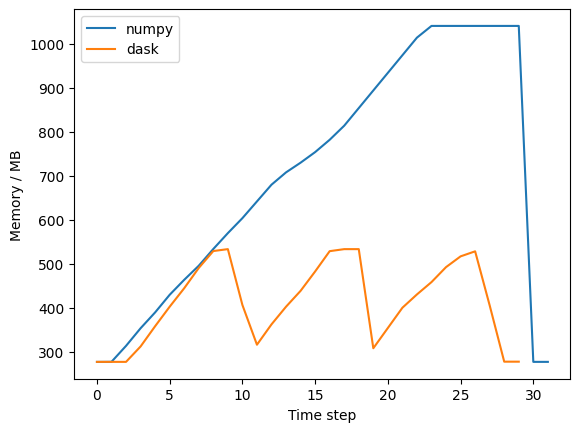

In [63]:
def sum_with_numpy():
    # Serial implementation
    np.arange(10**8).sum()

def sum_with_dask():
    # Parallel implementation
    work = da.arange(10**8).sum()
    work.compute()

memory_numpy = memory_usage(sum_with_numpy, interval=0.01)
memory_dask = memory_usage(sum_with_dask, interval=0.01)

# Plot results
plt.plot(memory_numpy, label='numpy')
plt.plot(memory_dask, label='dask')
plt.xlabel('Time step')
plt.ylabel('Memory / MB')
plt.legend(loc='best')
plt.show()

una gráfica que puede explicar como se distribuye y paraleliza sin picos

You also use Dask profiling options:

In [64]:
from dask.diagnostics import Profiler, ResourceProfiler
work = da.arange(10**8).sum()
with Profiler() as prof, ResourceProfiler(dt=0.001) as rprof:
    result2 = work.compute()

from bokeh.plotting import output_notebook
from dask.diagnostics import visualize
visualize([prof,rprof], output_notebook())

GridPlot(id='p1102', ...)

In [65]:
with ResourceProfiler(dt=0.001) as rprof2:
    result = np.arange(10**8).sum()
visualize([rprof2], output_notebook())

figure(id='p1106', ...)

# <font color="red"> Dask DataFrames</font>

- Pandas is great for tabular datasets that fit in memory.
- Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM.
- Dask DataFrames:
     - Coordinate many Pandas DataFrames, partitioned along an index.
     - Support a large subset of the Pandas API.
- One operation on a Dask DataFrame triggers many Pandas operations on the constituent pandas DataFrames in a way that is mindful of potential parallelism and memory constraints.
- Some of the operations that are really fast if you use Dask Dataframes:
     - Arithmetic operations (multiplying or adding to a Series)
     - Common aggregations (`mean`, `min`, `max`, `sum`, etc.)
     - Calling `apply`
     - Calling `value_counts()`, `drop_duplicates()` or `corr()`
     - Filtering with `loc`, `isin`, and row-wise selection

![fig_df](https://pythondata.com/wp-content/uploads/2016/11/Screen-Shot-2016-11-24-at-6.52.24-PM-168x300.png)

### <font color="green"> NYC Flights Dataset - Ejemplo con datos reales</font>

Data is specific to flights (in 1990's) out of the three airports in the New York City area.

En este ejemplo se puede ver una gran ventaja de Dask,
cómo puede manejar varios ficheros csv:

Esto se debe a que para dask son particiones en chuncks que se van creando y no lo ve como ficheros sino como esas particiones

Download the remote data:

In [66]:
import urllib.request

print("\t Downloading NYC dataset...", end="\n", flush=True)

url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
filename, header = urllib.request.urlretrieve(url, "nycflights.tar.gz")

print("\t Done!", flush=True)

	 Done!


In [67]:
!ls -lrt

total 43740
drwxr-xr-x 1 root root     4096 Sep 18 13:25 sample_data
-rw-r--r-- 1 root root   663236 Sep 19 17:19 mydask.png
-rw-r--r-- 1 root root 44120091 Sep 19 17:43 nycflights.tar.gz


Extract the `.csv` files from the tar file:

In [68]:
import tarfile

with tarfile.open(filename, mode="r:gz") as flights:
     flights.extractall("data/")

In [69]:
!ls -lrt data/nycflights

total 229600
-rw-r--r-- 1 502 staff 22611683 Jun 29  2017 1990.csv
-rw-r--r-- 1 502 staff 21535597 Jun 29  2017 1991.csv
-rw-r--r-- 1 502 staff 21783667 Jun 29  2017 1992.csv
-rw-r--r-- 1 502 staff 21495608 Jun 29  2017 1993.csv
-rw-r--r-- 1 502 staff 21696030 Jun 29  2017 1994.csv
-rw-r--r-- 1 502 staff 25170054 Jun 29  2017 1995.csv
-rw-r--r-- 1 502 staff 24979433 Jun 29  2017 1996.csv
-rw-r--r-- 1 502 staff 24952545 Jun 29  2017 1997.csv
-rw-r--r-- 1 502 staff 24903801 Jun 29  2017 1998.csv
-rw-r--r-- 1 502 staff 25952466 Jun 29  2017 1999.csv


Read all the files at once:

In [72]:
import os

df = dd.read_csv(os.path.join("data", "nycflights", "*.csv"),
                parse_dates={"Date": [0, 1, 2]})
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,string,int64,float64,float64,int64,float64,float64,float64,string,string,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


- The representation of the dataframe object contains no data.
- `pandas.read_csv` reads in the entire file before inferring datatypes.
- `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file). These inferred datatypes are then enforced when reading all partitions.

Ahora se puede ver aquí también una gran ventaja de Dask,

cómo puede manejar varios ficheros csv con el siguiente comando:

Esto se debe a que para dask son particiones en chuncks que av creando y no lo ve como ficheros sino como esas particiones

Podemos ver que la representación del objeto dataframe no contiene datos, pero informa sobre los tipos de datos



We can display the first few rows:

In [73]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


If we display the last few rows, we have a problem:

In [74]:
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

El error se debe a tipos de datos que tiene que gestionar dask

cuando no pueden ser inferidos correctamente hay que indicarlo a mano

In [75]:
df = dd.read_csv(os.path.join("data", "nycflights", "*.csv"),
                parse_dates={"Date": [0, 1, 2]},
                dtype={'TailNum': str,
                       'CRSElapsedTime': float,
                       'Cancelled': bool})

Se corrigen los errores especificando los tipos de datos

In [76]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


### <font color="blue">Perform Operations as with `Pandas DataFrames`</font>

**Maximum value of a column**:

- We now want to compute the maximum of the `DepDelay` column.
- With `Pandas`, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums.
- `dask.dataframe` allows us to write pandas-like code that operates on large than memory datasets in parallel.

al visualizar vemos esos ejemplos de cada uno de los ficheros

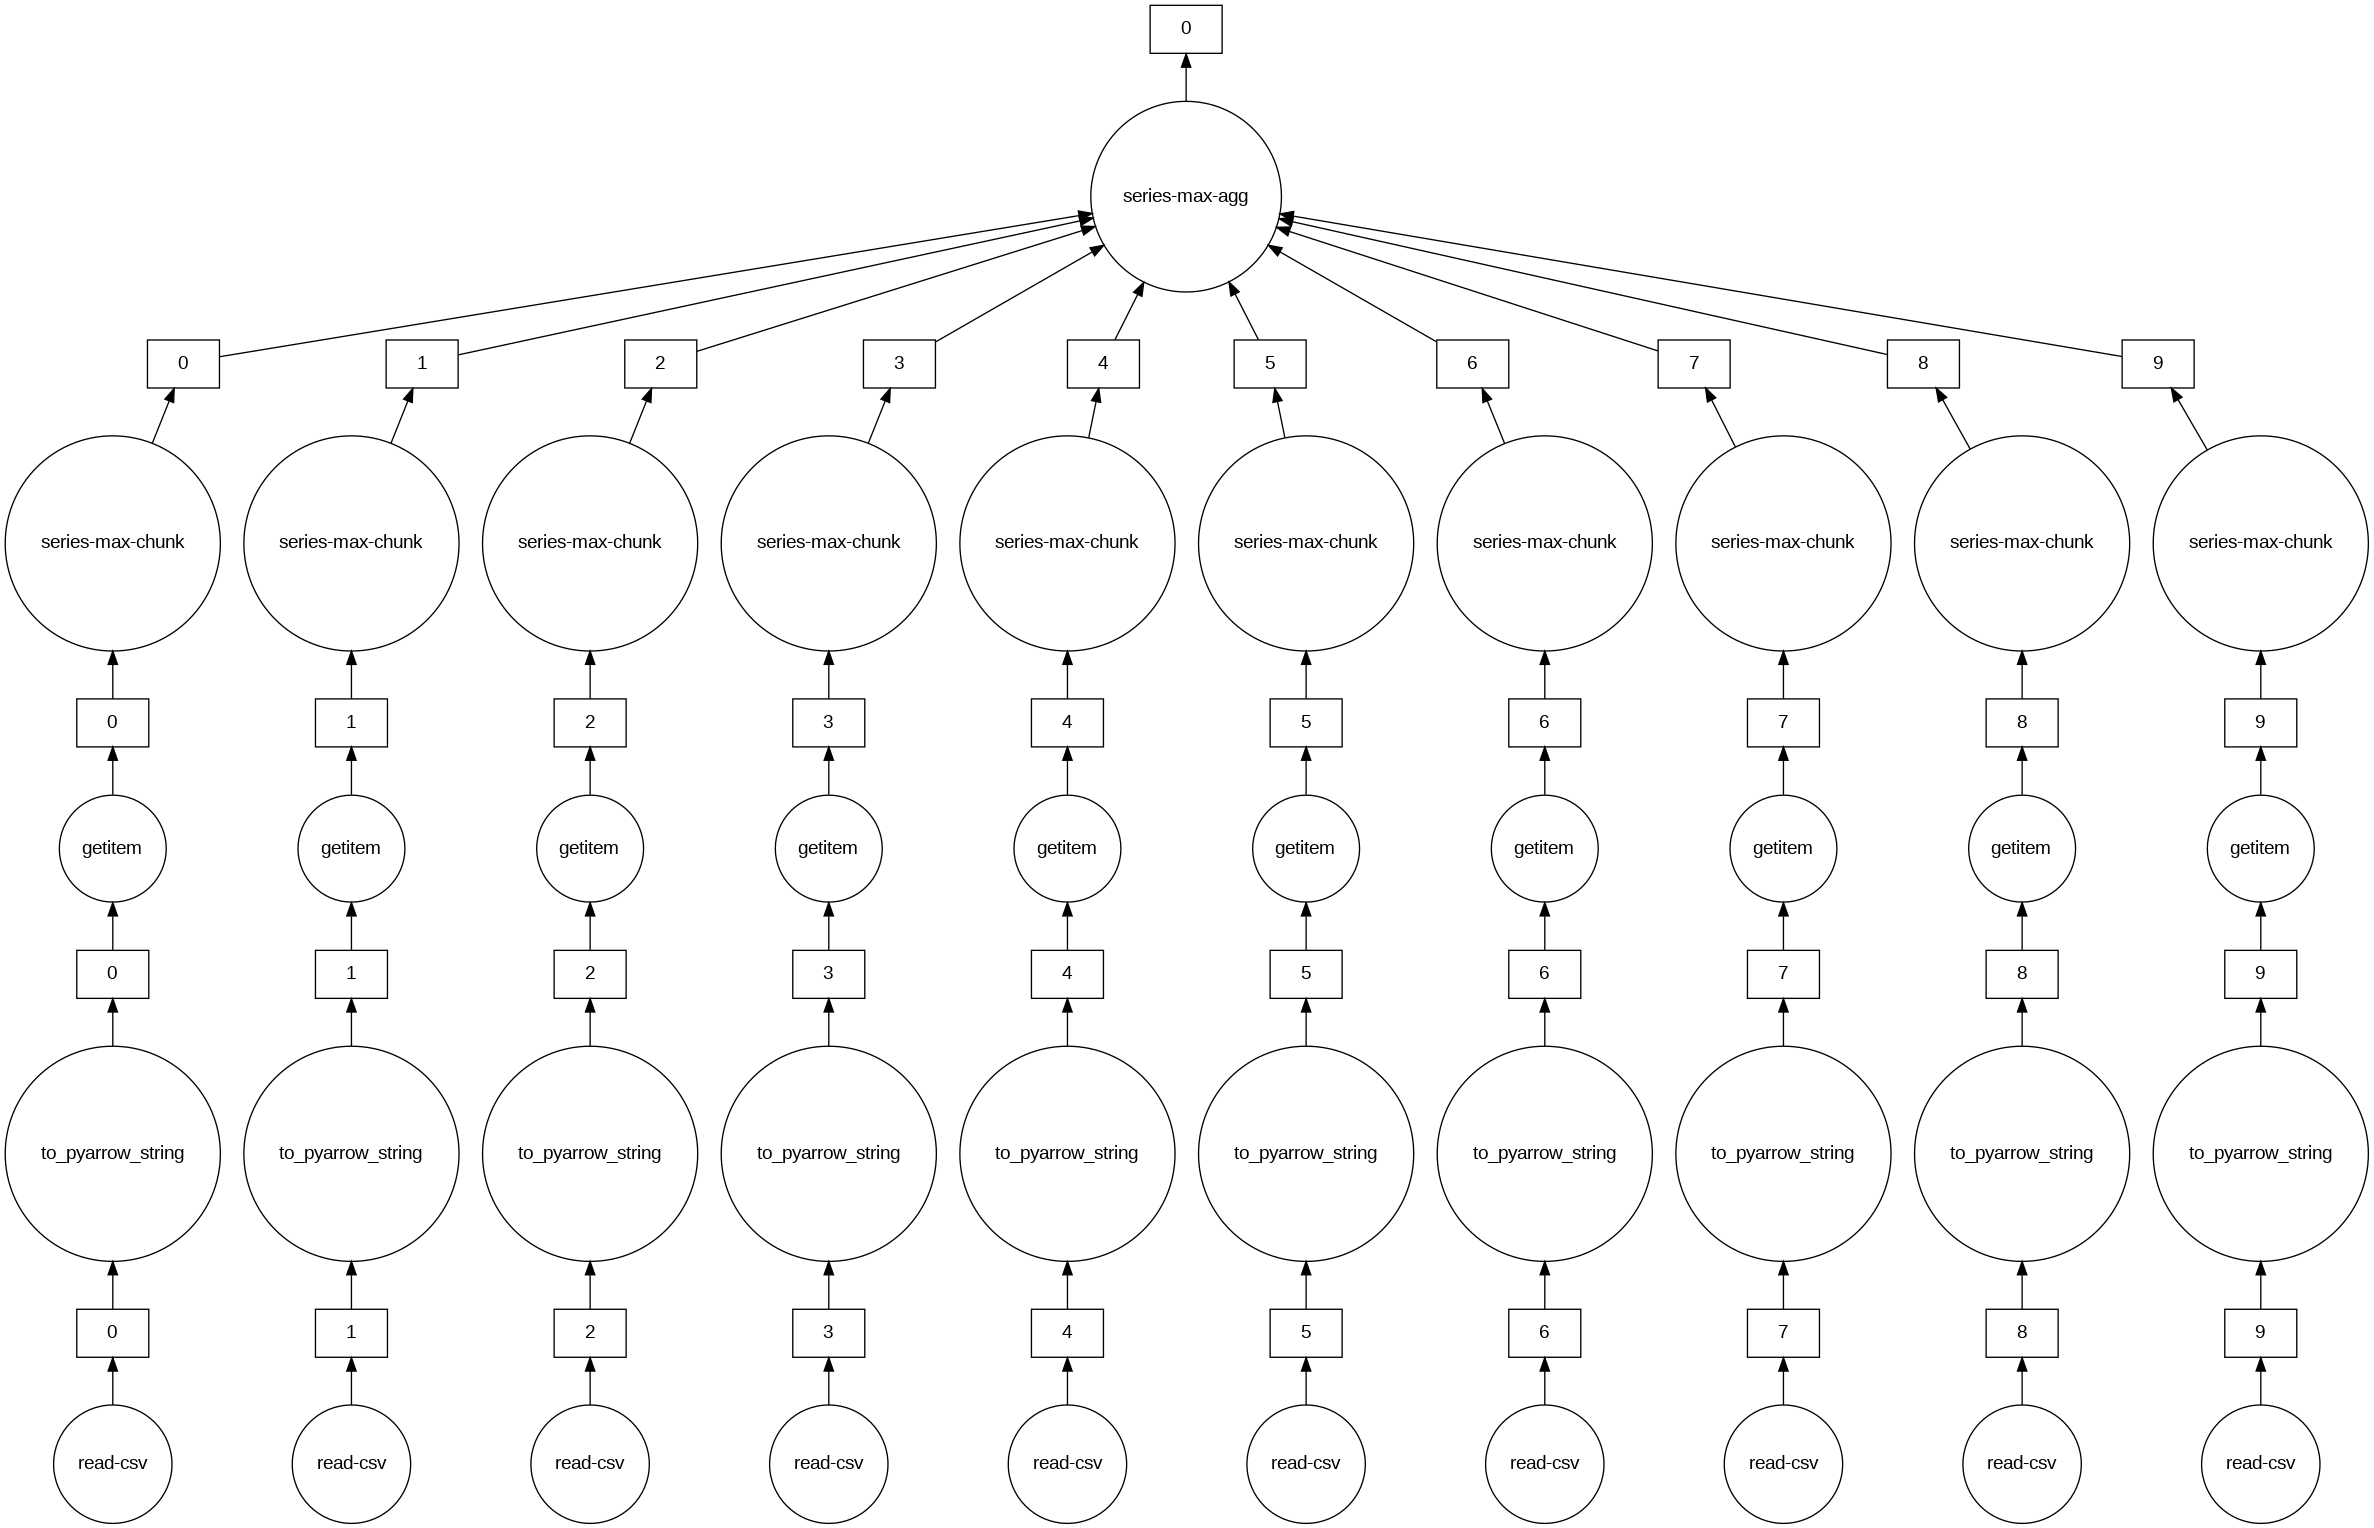

In [77]:
df.DepDelay.max().visualize()

**Plotting**

<Axes: xlabel='DayOfWeek', ylabel='DepDelay'>

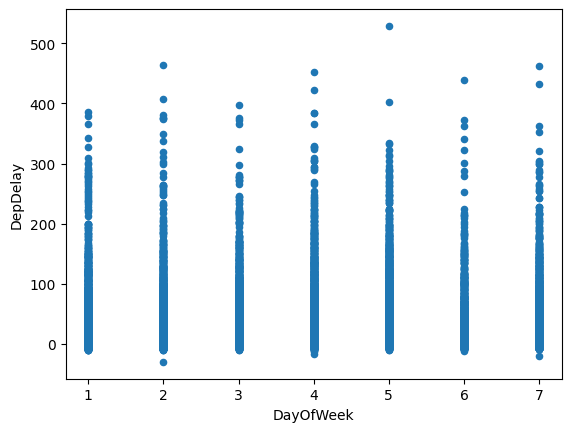

In [80]:
df[df.Dest == 'PIT'].compute().plot(kind='scatter',
                                    x="DayOfWeek",
                                    y="DepDelay")

**Varias operaciones**

Similar a lo que hacemos con pandas (transparente al usuario) pero ahora estamos aprovechando los recursos que nos ofrece DASK

Number of non-cancelled flights:

In [81]:
len(df[~df.Cancelled])

2540961

Number of non-cancelled flights were taken from each airport:

In [82]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

,Origin
Origin,
EWR,1139451
JFK,427243
LGA,974267


Average departure delay from each airport:

In [83]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

,DepDelay
DayOfWeek,
1,8.096565
2,8.149109
3,9.141912
4,10.538275
5,11.476687
6,7.824071
7,8.994296


Group by destinations and count:

In [84]:
df.groupby("Dest").count().compute()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
Dest,,,,,,,,,,,,,,,,,,,,
ABE,111,111,101,111,101,111,111,111,0,101,111,0,101,101,111,111,0,0,111,111
ALB,998,998,943,998,942,998,998,998,0,942,998,0,942,943,998,998,0,0,998,998
ATL,132372,132372,128855,132372,128605,132372,132372,132372,78183,128605,132372,75553,128605,128855,132372,132372,78183,78183,132372,132372
BDL,6208,6208,6071,6208,6067,6208,6208,6208,354,6067,6208,350,6067,6071,6208,6208,354,354,6208,6208
BGR,516,516,504,516,503,516,516,516,0,503,516,0,503,504,516,516,0,0,516,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AUS,787,787,776,787,775,787,787,787,787,775,787,775,775,776,787,787,787,787,787,787
CRP,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
HNL,569,569,569,569,563,569,569,569,569,563,569,563,563,569,569,569,569,569,569,569


In [85]:
df.groupby("Dest")["ArrDelay"].mean().compute()

,ArrDelay
Dest,
ABE,4.059406
ALB,4.128450
ATL,10.897796
BDL,3.507664
BGR,9.654076
...,...
AUS,8.054194
CRP,13.000000
HNL,-1.943162


In [86]:
df[df.ArrDelay+df.DepDelay>30.0].groupby("Dest").Dest.count().compute()

,Dest
Dest,
ABE,23
ALB,134
ATL,27989
BDL,870
BGR,123
...,...
AUS,195
CRP,1
HNL,103


**Compartir resultados intermedios**

- A veces hacemos la misma operación más de una vez.
- Para la mayoría de las operaciones, `dask.dataframe` realiza un hash de los argumentos, lo que permite compartir los cálculos duplicados y calcularlos una sola vez.

In [87]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [88]:
%%time
mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 21.9 s, sys: 544 ms, total: 22.5 s
Wall time: 15.3 s


We pass both to a single `compute` call:

In [89]:
%%time

mean_delay_res, std_delay_res = da.compute(mean_delay, std_delay)

CPU times: user 11 s, sys: 272 ms, total: 11.3 s
Wall time: 8.64 s


The task graphs for both results are merged when calling dask.compute, allowing shared operations to only be done once instead of twice.

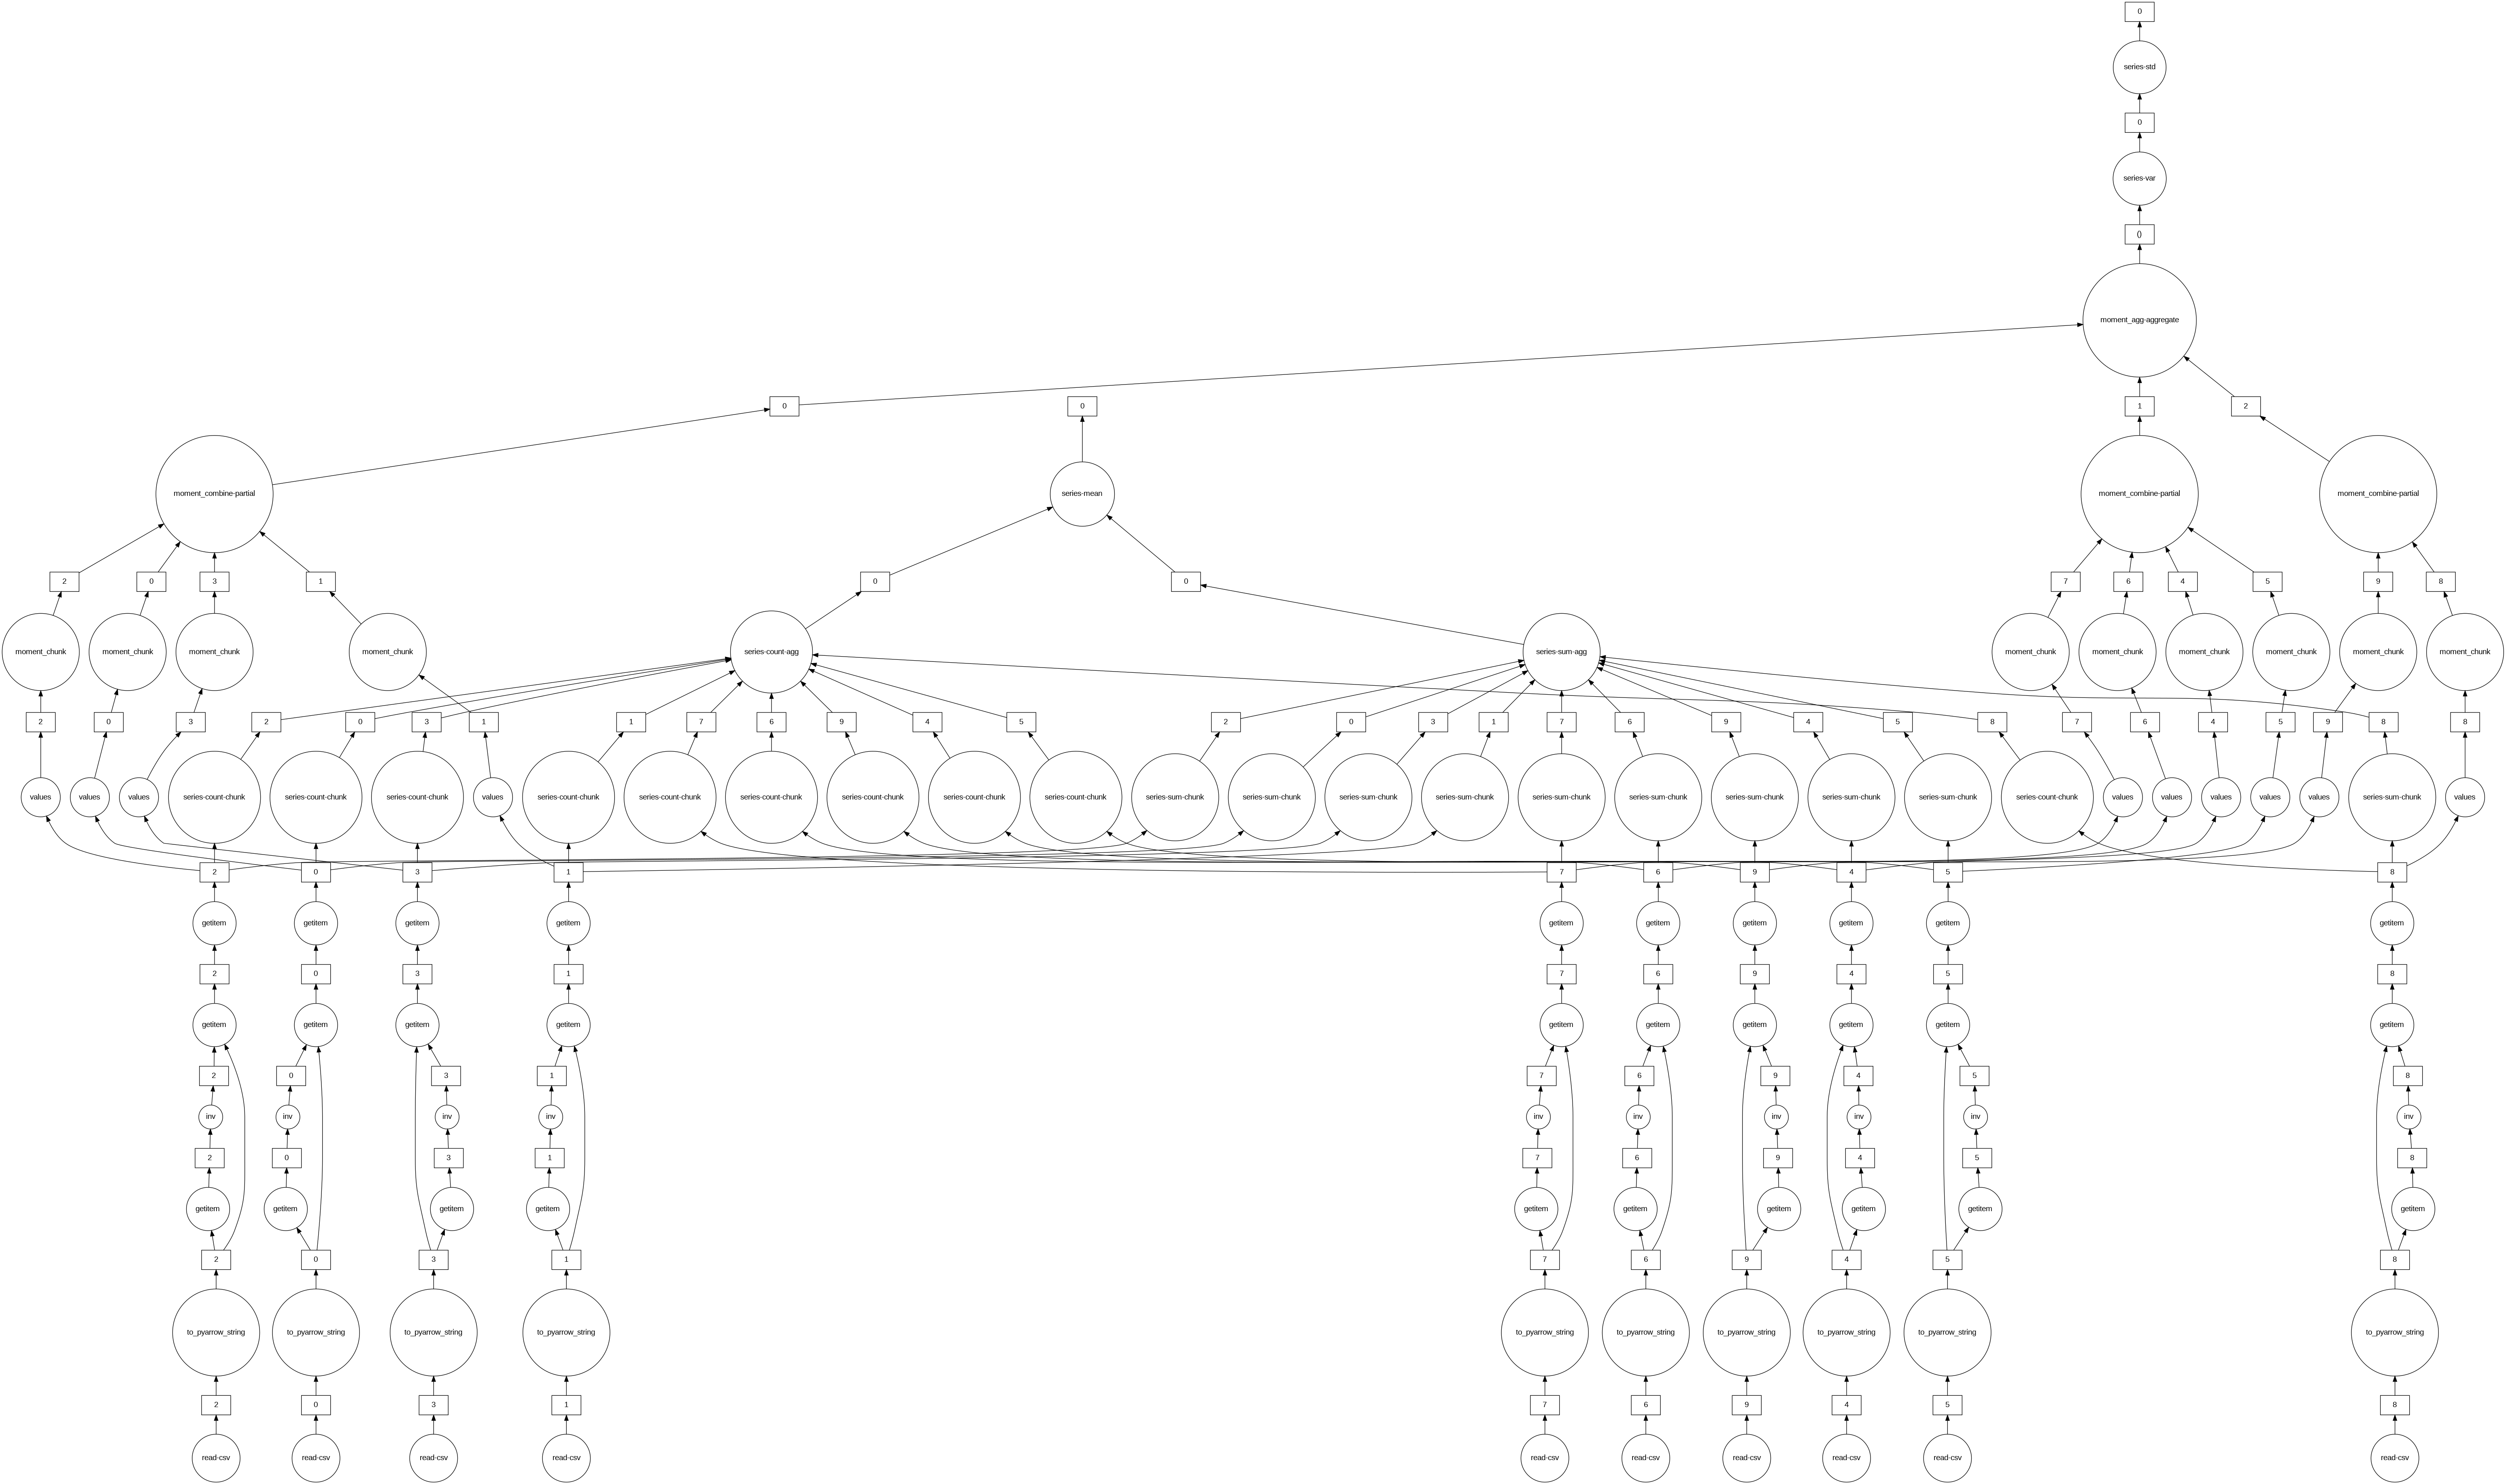

In [90]:
dask.visualize(mean_delay, std_delay)

### Exemple

- Considera el siguiente código que calcula el retraso medio de salida por aeropuerto.
- Paralelizar el código usando Dask.

In [94]:
%%time

sum_delays = list()
count_delays = list()

for file_name in list_files:
    pddf = pd.read_csv(file_name)
    by_origin = pddf.groupby('Origin')
    loc_total = by_origin.DepDelay.sum()
    loc_count = by_origin.DepDelay.count()
    sum_delays.append(loc_total)
    count_delays.append(loc_count)

total_delays = sum(sum_delays)
n_flights = sum(count_delays)
mean_delays = total_delays / n_flights
print("Mean delays: {}".format(mean_delays))

Mean delays: Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
CPU times: user 6.08 s, sys: 89 ms, total: 6.17 s
Wall time: 6.23 s


In [93]:
# DASK
%%time

df.groupby("Origin")["DepDelay"].mean().compute()

CPU times: user 11 s, sys: 255 ms, total: 11.2 s
Wall time: 8.18 s


,DepDelay
Origin,
EWR,10.295469
JFK,10.351299
LGA,7.431142


### <font color="blue">Example of Machine Learning with Dask</font>

Sólo para explorar/investigar

Grab columns from the Dask DataFrame:

In [ ]:
df_train = df[["CRSDepTime", "CRSArrTime", "Cancelled"]]
df_train

,CRSDepTime,CRSArrTime,Cancelled
npartitions=10,,,
,int64,int64,bool
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


You can query the shape (note delayed # of sample):

In [ ]:
df_train.shape

(Delayed('int-d3707d6b-bc74-4519-ad76-07b4cd4d7e2a'), 3)

In [ ]:
num_cols = len(df_train.columns)
print(num_cols)

3


**Basic EDA**

We can get descriptive statistics:

In [ ]:
df_train.describe().compute()

[########################################] | 100% Completed | 3.76 s


,CRSDepTime,CRSArrTime
count,2.611892e+06,2.611892e+06
mean,1.322913e+03,1.513336e+03
std,4.731965e+02,4.950296e+02
min,0.000000e+00,0.000000e+00
25%,9.200000e+02,1.135000e+03
50%,1.430000e+03,1.546000e+03
75%,1.755000e+03,1.948000e+03
max,2.359000e+03,2.400000e+03


Perform searches and operations on the data:

In [ ]:
df_train.isnull().sum().compute()

[########################################] | 100% Completed | 5.09 s


CRSDepTime    0
CRSArrTime    0
Cancelled     0
dtype: int64

**Create the Model**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Dense(20,
                       input_dim=num_cols,
                       activation='relu'))
model.add(layers.Dense(1,  activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="sgd", )

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

**Train the Model**

Generate batches of data:

In [ ]:
def batch_data_generator(df, fraction=0.01):
    while True:
          batch = df.sample(frac=fraction)
          X = batch.iloc[:, :-1]
          y = batch.iloc[:, -1]
          yield (X.compute(), y.compute())

We never run of memory while doing the training:

```
   steps_per_epoch * batch_size = number_of_rows_in_train_data
```

In [ ]:
model.fit_generator(generator=batch_data_generator(df_train),
                    steps_per_epoch=100)

# <font color="red"> Task Schedulers</font>

- After Dask generates the task graphs, it needs to execute them on parallel hardware.
- It is the role of a task scheduler.
- There are different task schedulers. Each will consume a task graph and compute the same result, but with different performance characteristics.

![schedulers](https://docs.dask.org/en/latest/_images/dask-overview.svg)

Image Source: [https://docs.dask.org/en/latest/](https://docs.dask.org/en/latest/)


Dask networks are composed of three pieces:
- **Centralized scheduler**: Manages workers and assigns the tasks that need to be completed by them.
- **Workers**: Are threads, processes, or separate machines in a cluster. They execute the computations from the computation graph: do the calculations, hold onto results, and communicate results to each other.
- **One or multiple clients**: interact (Jupyter noteboooks or scripts) with users and submit work to the scheduler for execution on the workers.


![networks](https://miro.medium.com/max/700/0*9JHQAjTVoKbm2f4X.png)
Image Source: [Steven Gon](https://gongster.medium.com/dask-an-introduction-and-tutorial-b42f901bcff5)

To execute the task graphs there are two types of schedulers:
* **Single machine**: Provides basic features on a local process or thread pool. It is simple and cheap to use, although it can only be used on a single machine and does not scale
* **Distributed**: Offers more features, but also requires a bit more effort to set up. It can run locally or distributed across a cluster.

## <font color="blue"> Single Machine Scheduler</font>

Consider the following example:

In [ ]:
n = 10
data = [i+1 for i in range(n)]

out = list()
for x in data:
    y = dask.delayed(increment)(x)
    z = dask.delayed(double)(y)
    out.append(z)

totald = 0
for z in out:
    totald = dask.delayed(add)(totald, z)

**Single thread**

- The single-threaded synchronous scheduler executes all computations in the local thread with no parallelism at all.
- It is useful for debugging or profiling.

In [ ]:
%time totald.compute(scheduler='synchronous')

**Local threads**

Uses `multiprocessing.pool.ThreadPool`

Use all the processors

In [ ]:
%time totald.compute(scheduler='threads')

Use some of the processors:

In [ ]:
%time totald.compute(scheduler='threads', num_workers=2)

We can choose to use a single thread:

In [ ]:
%time totald.compute(scheduler='single-threaded')

**Local processes**

- The multiprocessing scheduler executes computations with a local `multiprocessing.Pool`.
- Every task and all of its dependencies are shipped to a local process, executed, and then their result is shipped back to the main process.
- Moving data to remote processes and back can introduce performance penalties, particularly when the data being transferred between processes is large.
- The multiprocessing scheduler is an excellent choice when workflows are relatively linear, and so does not involve significant inter-task data transfer as well as when inputs and outputs are both small, like filenames and counts.

In [ ]:
import multiprocessing
print (multiprocessing.cpu_count())

Use all the processors:

In [ ]:
%time result = totald.compute(scheduler='processes')

Use some of the processors:

In [ ]:
%time result = totald.compute(scheduler='processes', num_workers=2)

In [ ]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [ ]:
result = totald.compute(scheduler='processes', num_workers=2)

### Threads or Processes?

- **Use the threaded scheduler** if your computation is dominated by non-Python code, as is primarily the case when operating on numeric data in NumPy arrays, Pandas DataFrames, or using any of the other C/C++/Cython based projects in the ecosystem.
   - It is lightweight.
   - Little overhead.
   - Tranferring data between tasks not expensives because everything happens in the same process.
- **Use the multipeocessing scheduler** if your computation is dominated by processing pure Python objects like strings, dictionaries, or lists.
   - It is lightweight.
   - Every task and all of its dependencies are shipped to a local process, executed, and then their result is shipped back to the main process.
   - Moving data to remote processes and back can introduce performance penalties, particularly when the data being transferred between processes is large.
   - Is an excellent choice when workflows are relatively linear, and so does not involve significant inter-task data transfer as well as when inputs and outputs are both small, like filenames and counts.

## <font color="blue">Distributed Scheduler</font>

- The Dask distributed scheduler can either be setup on a cluster or run locally on a personal machine.
- It is a centrally managed, distributed, dynamic task scheduler.
     - The central dask-scheduler process coordinates the actions of several dask-worker processes spread across multiple machines and the concurrent requests of several clients.
     - The scheduler is asynchronous and event-driven, simultaneously responding to requests for computation from multiple clients and tracking the progress of multiple workers.
     - The event-driven and asynchronous nature makes it flexible to concurrently handle a variety of workloads coming from multiple users at the same time while also handling a fluid worker population with failures and additions.
     - Workers communicate amongst each other for bulk data transfer over TCP.
- To set up `dask.distributed`, we need to create a client instance by calling `Client` class from `dask.distributed`.
- It will internally create a dask scheduler and dask workers.
- We will get the **link of the dashboard** where we can analyze tasks running in parallel.
- We can pass a number of workers (using the `n_workers` argument) and threads to use per worker process (using the `threads_per_worker` argument).
- As soon as you create a client, Dask will automatically start using it.

In [ ]:
from dask.distributed import Client
client = Client()
client = Client(n_workers=3, threads_per_worker=4)
client.cluster

If you aren’t in jupyterlab and using the `dask-labextension`, you can  click the `Dashboard` link to open up the diagnostics dashboard.

In [ ]:
import random

def random_slow_add(x, y):
    time.sleep(random.randrange(3,10))
    return x + y

In [ ]:
results = list()

for x in data:
    y = dask.delayed(random_slow_add)(x, 1)
    results.append(y)

total = dask.delayed(sum)(results)

In [ ]:
%time result = total.compute()
result

Shut down the cluster:

In [ ]:
client.close()

**<font color="red">Things to Consider</font>**

- Each Dask task has overhead (about 1 ms). If you have a lot tasks this overhead can add up. It is a good idea to give each task more than a few seconds of work.
- To better understand how your program is performing, check the [Dask Performance Diagnostics](https://distributed.dask.org/en/latest/diagnosing-performance.html) documentation. You can also view the [video](https://docs.dask.org/en/stable/diagnostics-distributed.html) to find out how to group your work into fewer, more substantial tasks. This might mean that you call lazy operations at once instead of individually. This might also repartitioning your dataframe(s).
- A good rule of thumb for choosing number of threads per Dask worker is to choose the square root of the number of cores per node.
     - In general more threads per worker are good for a program that spends most of its time in NumPy, SciPy, Numba, etc., and fewer threads per worker are better for simpler programs that spend most of their time in the Python interpreter.
- The Dask scheduler runs on a single thread, so assigning it its own node is a waste.
- There is no hard limit on Dask scaling. The task overhead though will eventually start to swamp your calculation depending on how long each task takes to compute.

## <font color="blue"> Example with DataFrame</font>

Build a Pandas DataFrame with 100000 rows and two columns with values selected randomly between 1 and 1000.

In [ ]:
num_rows = 100000
df = pd.DataFrame({'X':np.random.randint(1000, size=num_rows),
                   'Y':np.random.randint(1000, size=num_rows)})
df

Write a function that computes the sum of square for each column of the DataFrame.

In [ ]:
def add_squares(df):
    return df.X**2 + df.Y**2

Measure the time it takes to call the function:

In [ ]:
%%timeit
df['add_squares'] = df.apply(add_squares,axis=1)

In [ ]:
df

### <font color="green">Parallelize using Dask `Map_Partition`</font>

We construct a Dask DataFrame from pandas dataframe using `from_pandas` function and specify the number of partitions (`nparitions`) to break this dataframe into.

```python
   dd = ddf.from_pandas(df, npartitions=N)
```

`ddf` is the name you imported Dask Dataframes with, and `npartitions` is an argument telling the Dataframe how you want to partition it.

Each partition will run on a different thread, and communication between them will become too costly if there are too many.

We will break into 4 partitions (number of available cores):

In [ ]:
ddf = dd.from_pandas(df, npartitions=4)

We will apply `add_squares` method on each of these partitions:

In [ ]:
%%time

ddf['z'] = ddf.map_partitions(add_squares,
                               meta=(None, 'int64')).compute()

In [ ]:
def myfunc(x, y):
    return y * (x**2 + 1)

In [ ]:
%%time

df1 = df.apply(lambda row: myfunc(row.X, row.Y), axis=1)

In [ ]:
import multiprocessing
ddf = dd.from_pandas(df, npartitions=4*multiprocessing.cpu_count())
ddf

In [ ]:
%%time

ddfz = ddf.map_partitions(lambda data:
                              data.apply(lambda row: myfunc(row.X, row.Y), axis=1)).compute(scheduler='processes')